In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Quadratic dependence
Given:
- Random variable transformation $x$ → $y = x^2$
- $x \sim \mathcal{N}(2, 1)$

1. generate $\sim 10^6$ samples and compare numerically
2. compare $y$ histogram with analytic formula
3. try different $x$ distribution e.g. Poisson with $\mu = 3$

Correct analytical formula for $Y \equiv X^2$ PDF:
- CDF, by definition $F_Y(y) = P(Y < y) = P(X^2 < y) = P(- \sqrt{y} < X < \sqrt{y}) = F_{X}(\sqrt{y}) - F_X(- \sqrt{y})$
- Differentiating to get PDF $\displaystyle f_Y(Y) = \frac{d F_Y(y)}{d y} =  \frac{1}{2\sqrt{y}}f_{X}(\sqrt{y}) + \frac{1}{2\sqrt{y}} f_X(- \sqrt{y})$

Incorrect analytical formula (assumes monotonous transformation which is not true in this case):
$f_Y(y) = f_X(\sqrt{y}) |\frac{1}{2 \sqrt{y}}|$

It **becomes** correct if we limit $x$ range to $[0, \infty)$, thus making the transformation monotonous.

In [2]:
SAMPLE_SIZE = 1_000_000

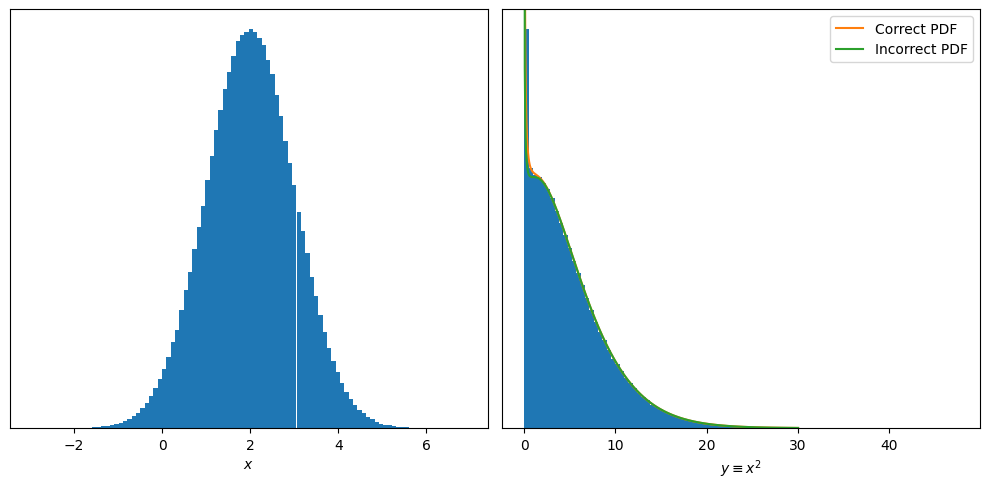

In [3]:
x_rv=scipy.stats.norm(loc=2, scale=1)

x_sample = x_rv.rvs(size=SAMPLE_SIZE)
y_sample = x_sample**2

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(x_sample, bins=100, density=True)
ax1.set_xlabel("$x$")
ax1.set_yticks([])

ax2.hist(y_sample, bins=100, density=True)
hist_ylim = ax2.get_ylim()
y_range = np.linspace(0, 30, num=500) + 1e-3
sqrt_y = np.sqrt(y_range)
ax2.plot(y_range, ((x_rv.pdf(sqrt_y) + x_rv.pdf(- sqrt_y)) / (2 * sqrt_y)), label="Correct PDF")
ax2.plot(y_range, (x_rv.pdf(sqrt_y) / (2 * sqrt_y)), label="Incorrect PDF")
ax2.set_xlabel("$y \equiv x^2$")
ax2.set_yticks([])
ax2.set_ylim(hist_ylim)  # not counting PDF peak at 0
ax2.legend()

plt.tight_layout()
plt.show()

With Poisson distribution, $\mu = 3$

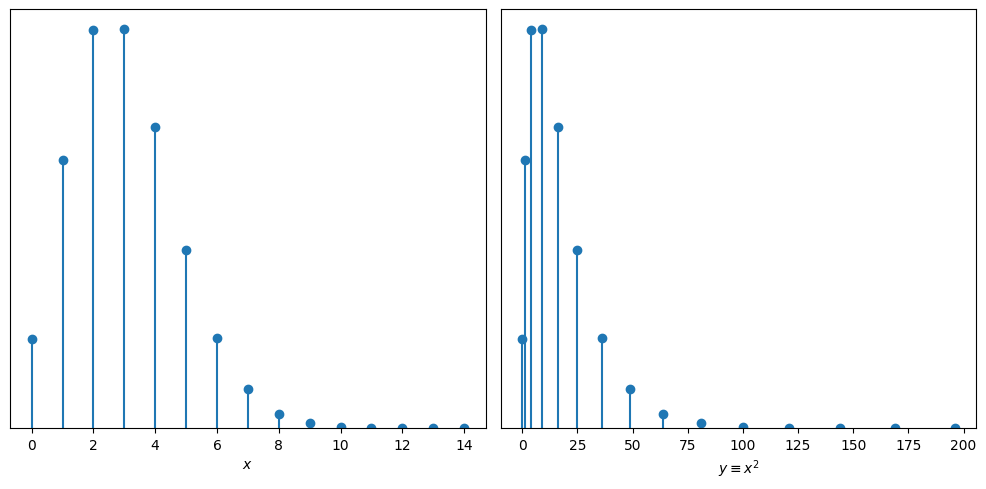

In [4]:
x_rv=scipy.stats.poisson(3)

x_sample = x_rv.rvs(size=SAMPLE_SIZE)
y_sample = x_sample**2

discrete_bins = lambda sample: np.arange(sample.min(), sample.max() + 2) - 0.5
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

x_sample_hist, _ = np.histogram(x_sample, bins=discrete_bins(x_sample), density=True)
bin_cntr = discrete_bins(x_sample)[:-1] + 0.5
ax1.vlines(bin_cntr, 0, x_sample_hist)
ax1.scatter(bin_cntr, x_sample_hist)
ax1.set_xlabel("$x$")
ax1.set_ylim(0)
ax1.set_yticks([])

y_sample_hist, _ = np.histogram(y_sample, bins=discrete_bins(y_sample), density=True)
bin_cntr = discrete_bins(y_sample)[:-1] + 0.5
ax2.vlines(bin_cntr, 0, y_sample_hist)
ax2.scatter(bin_cntr[y_sample_hist > 0], y_sample_hist[y_sample_hist > 0])
ax2.set_xlabel("$y \equiv x^2$")
ax2.set_ylim(0)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Random variable ratio
- $x, y \sim \mathcal{N}(0, 1)$
- compute distribution of $u \equiv \frac{x}{y}$

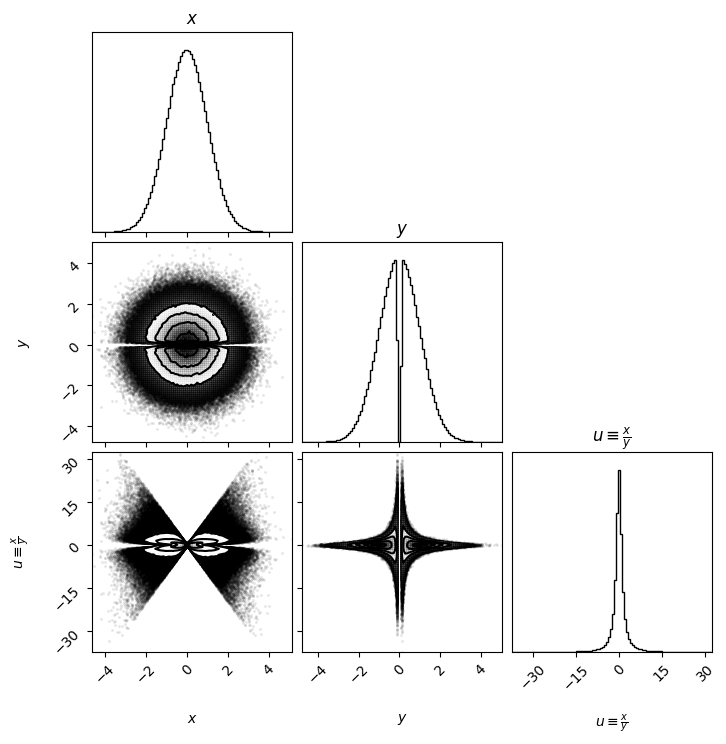

In [5]:
import corner

x_rv = scipy.stats.norm()
y_rv = scipy.stats.norm()

x_sample = x_rv.rvs(SAMPLE_SIZE)

# masking out very small y values to avoid very large values of ratio
y_sample = y_rv.rvs(SAMPLE_SIZE)

mask = np.abs(y_sample) > 1e-1

y_sample = y_sample[mask]
x_sample = x_sample[mask]

u_sample = x_sample / y_sample

_ = corner.corner(
    np.concatenate(
        [
            np.expand_dims(x_sample, axis=1),
            np.expand_dims(y_sample, axis=1),
            np.expand_dims(u_sample, axis=1),
        ],
        axis=1,
    ),
    bins=100,
    labels=["$ x $", "$y$", "$ u \equiv \\frac{x}{y} $"],
    show_titles=True,
    title_fmt=None,
)

# Bernoulli distribution
- compute and plot Binomial probabilities with $n = 150$
- $p = 0.1, 0.3, 0.5, 0.7, 0.9$
- no predefined functions!
- repeat for $n = 500$
- try do in Python in C++ 

In [6]:
from typing import Iterable
import math


def log_factorial(n: int) -> int:
    return sum(np.log(i) for i in range(1, n + 1))


def binomial_probabilities(n: int, p: float, k: Iterable[int]) -> list[float]:
    res: list[float] = []
    for k_i in k:
        res.append(
            math.exp(
                log_factorial(n)
                - log_factorial(k_i)
                - log_factorial(n - k_i)
                + k_i * np.log(p)
                + (n - k_i) * np.log(1 - p)
            )
        )
    return res

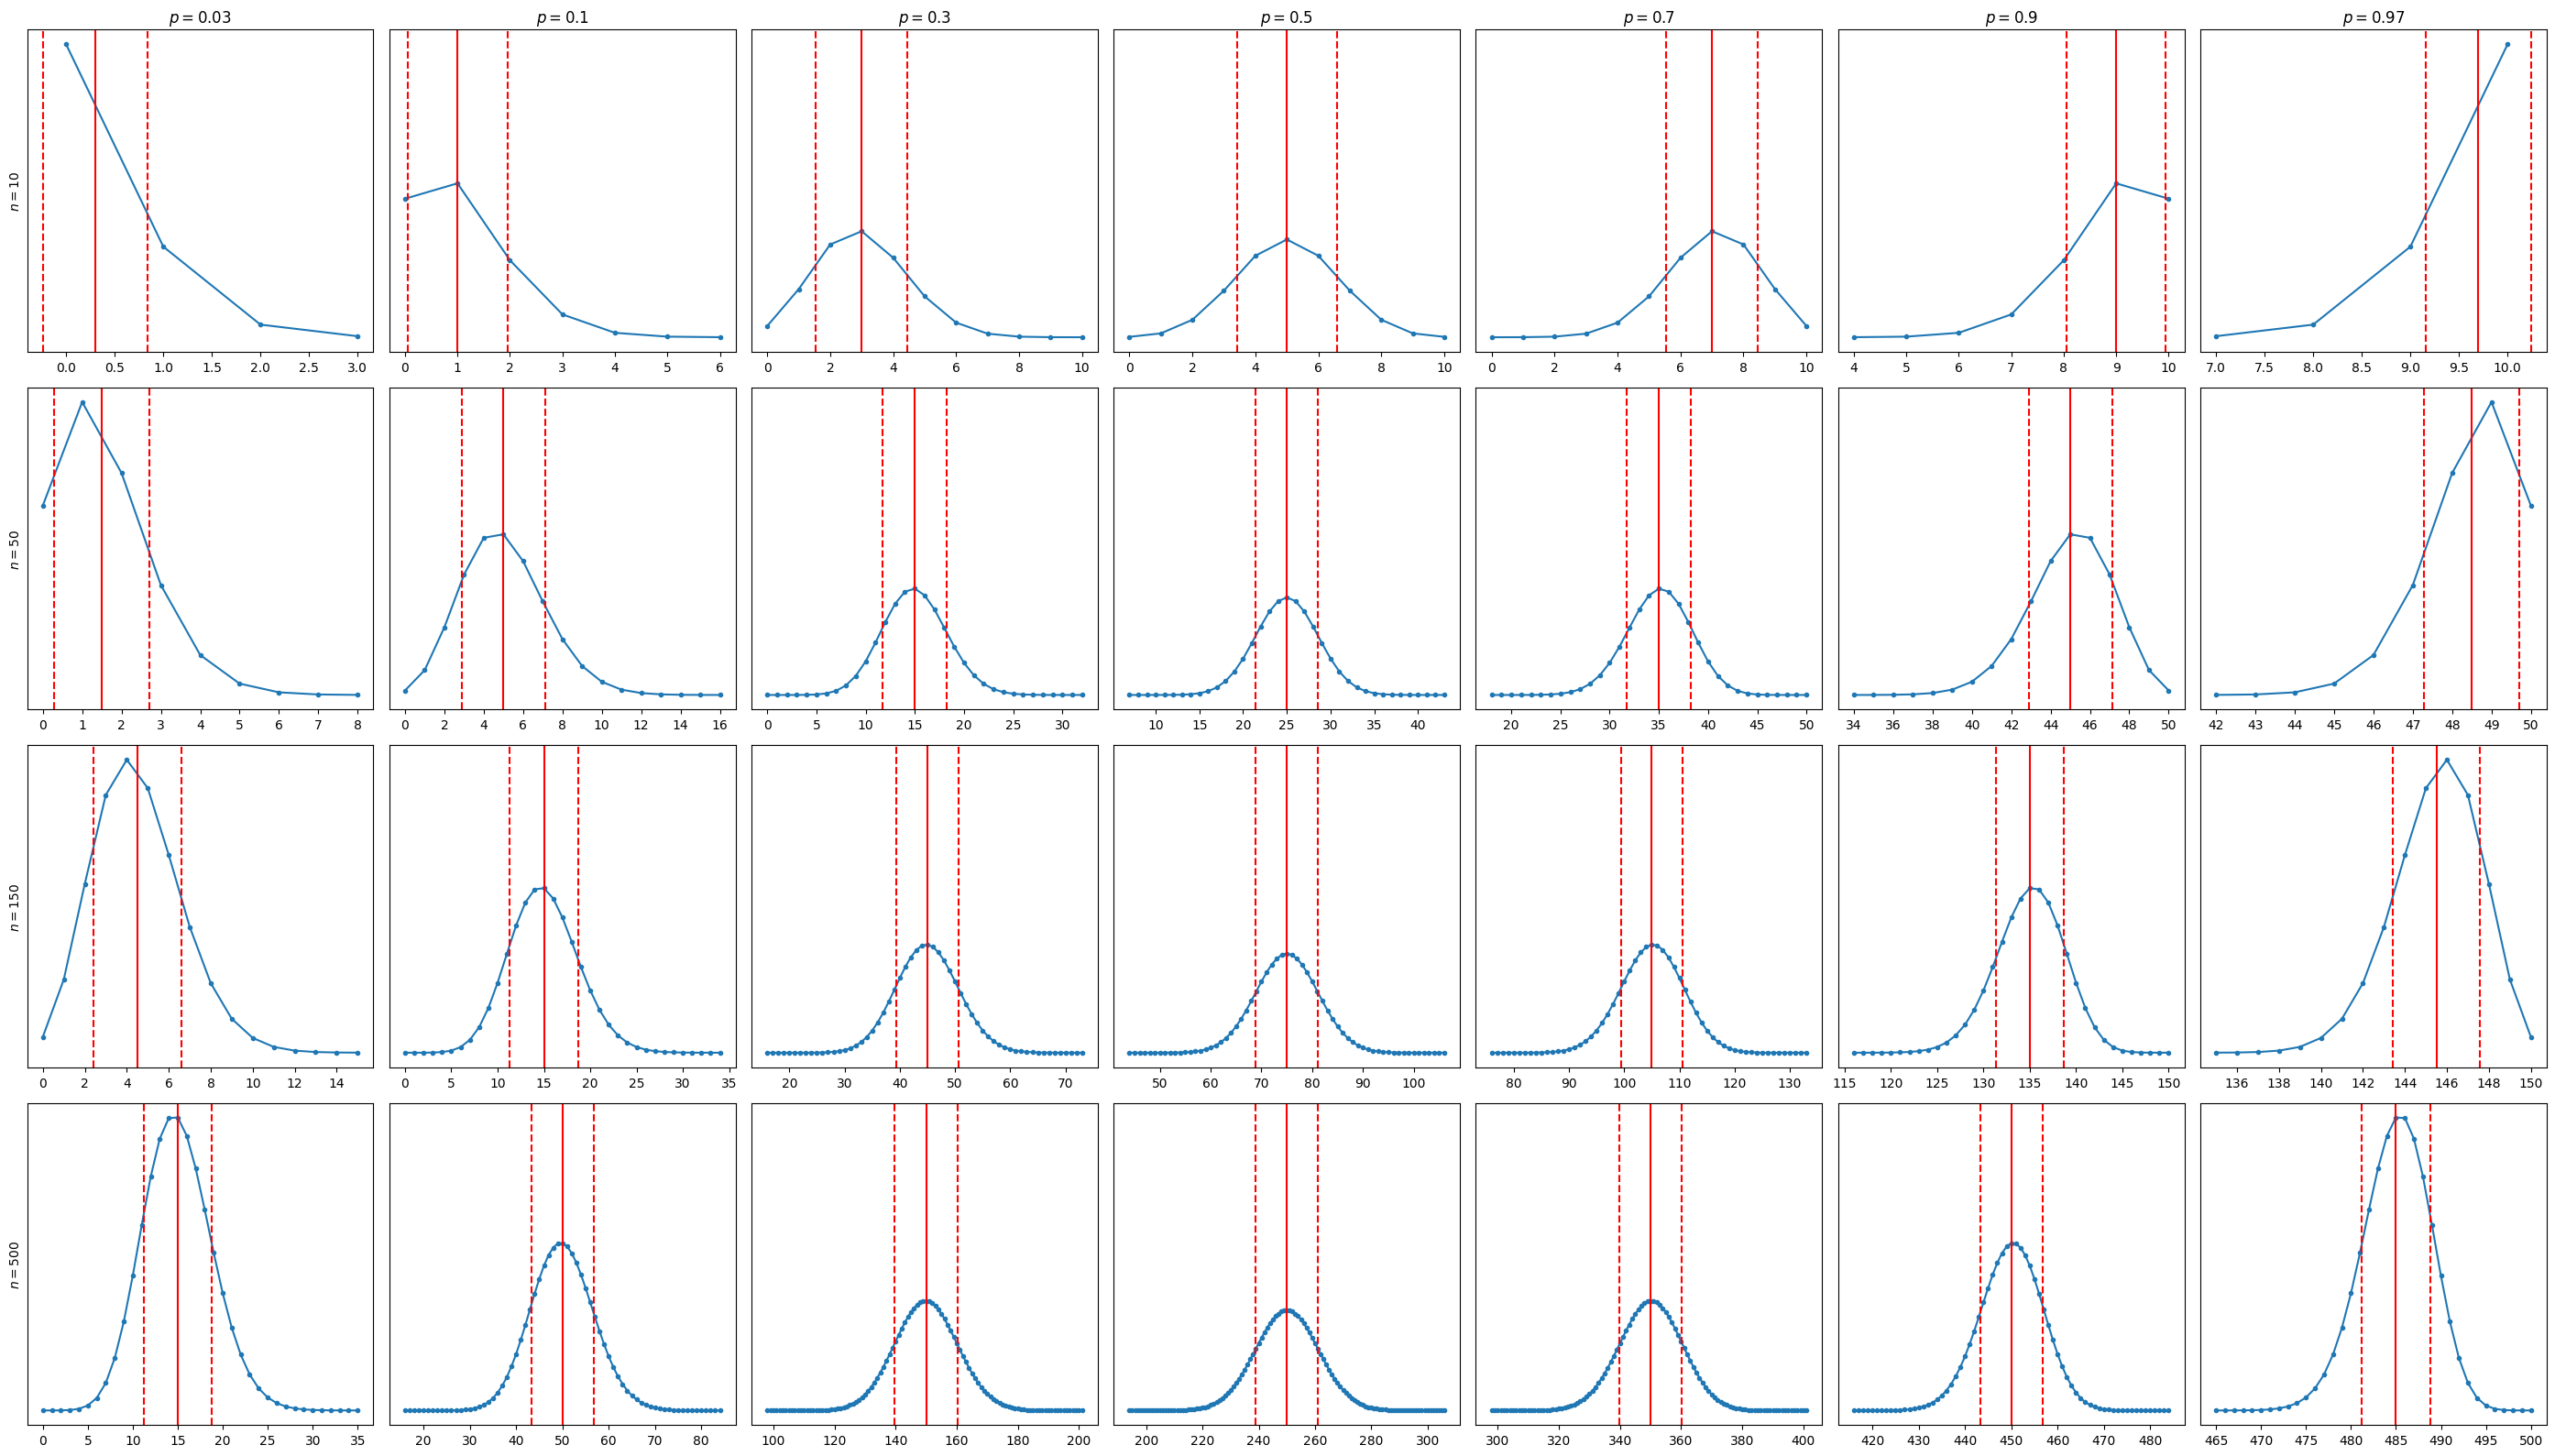

In [10]:
n_variants = [10, 50, 150, 500]
p_variants = [0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 0.97]

fig, axes = plt.subplots(
    ncols=len(p_variants),
    nrows=len(n_variants),
    figsize=(int(4 * len(p_variants)), 4 * len(n_variants)),
    sharey="row",
    # sharex="row",
)

for n, ax_row in zip(n_variants, axes):
    ax_row[0].set_ylabel(f"$ n = {n} $")
    for p, ax in zip(p_variants, ax_row):
        q = 1 - p
        mu = n * p
        sigma = math.sqrt(n * p * (1 - p))
        k_min = max(0, mu - 5 * sigma)
        k_max = min(mu + 5 * sigma, n)
        k = np.arange(k_min, k_max + 1, dtype="int")
        ax.plot(k, binomial_probabilities(n, p, k), ".-")
        ax.axvline(mu, color="r")
        ax.axvline(mu - sigma, color="r", linestyle="--")
        ax.axvline(mu + sigma, color="r", linestyle="--")
        if n == n_variants[0]:
            ax.set_title(f"$p = {p}$")
        ax.set_yticks([])

plt.tight_layout()
plt.show()